# Introduction to ML - Assignment 1 - April 9, 2022

## General principles for a correct model development: Read carefully!!!

**The pre-modeling phase aims to obtain a clean training and test database to feed the learning algorithms.**

It is a very (the most?) important phase of the model development process as the Garbage In-Garbage Out principle applies ... so take your time to get it right.

Once the raw data has been acquired (how to do that depends on the support and the characteristics of the raw data (structured or unstructured data)) in a suitable environment (pandas) the first thing is to do an **Exploratory Data Analysis - EDA**, in simple words ... **look the data**:
- make graphs (histograms, scatter plots, box-plots ...)
- analyze the marginal distributions (mean, variance, max, min, percentiles)
- analyze the joint distribution of the variables (correlations)

Once you have an idea of what your data is like, you can start addressing any (but almost certain) problems you will encounter ...

The most common answer these questions (not necessarily in this order ...):

- <mark style="background:yellow">**are there any non-numeric formats (strings) in the data?**</mark> $\Longrightarrow$ <b style="color: green">OK</b>
    - almost all ML algorithms can work only with numeric data (int or float) and therefore this data must be converted into numeric data.
    - in general this process goes under the name of **'category encoding'** and the type of encoding to use depends on the characteristics of the variables ...


- <mark style="background:yellow">**are there missing data for some variables**?</mark> 
$\Longrightarrow$ <b style="color: green">OK</b>
    - and if so what is the best strategy to manage them?
        - delete the variables?
        - delete observations with missing data?
        - replace the missing data with an estimate of the missing value?


  Which strategy to adopt depends on the number of observations and variables you have available...

- <mark style="background:yellow">**are there outliers in the variables**?</mark>
    - how do i identify them?
        - univariate or multivariate analysis...
    - how do I manage them?
        - delete observations with anomalous data? $\Longrightarrow$ <b style="color: red">Not a solution : can remove too many tuples</b>
        - replace the outliers with an estimate? $\Longrightarrow$ <b style="color: green">Solution</b>
    - are outliers really a problem? $\Longrightarrow$ <b style="color: red">WARNING : PROBLEM</b>
        - there are algorithms that are robust in the presence of outliers


  Again which strategy to adopt depends on the size of the sample you have available ...

<mark style="background:yellow">**Two points to remember**</mark>

- the principle less data = more variance always applies ...
- **if you use estimates to replace missing or outliers values** these estimates must be computed
    - **after** you have splitted the sample into training-test subsamples
    - <mark style="background:yellow">**on training data only**</mark> and then applied to test data

**How to organize these activities?**

- try to avoid spaghetti code
- try to write functions that group the operations that are related to the same transformation
- try to use Pipelines to organize the flow of data between these functions


**The paragraphs reported in each exercise are indicative only and serve to remind the student of the minimal set of analyzes that must be carried out. The student is free to add any other type of analysis he deems appropriate at his discretion**.

---

## Exercise 1 - Data Preprocessing

In this exercise, you need to process a data file that contains many invalid lines. You will find some null data and others field with various values (eg 'Missing' or NA) which indicate that the corresponding data is not valid. Furthermore, even in some numeric columns there may be characters (eg '-') which indicate the absence of a data. Also in this case you have to understand how to deal with the data (eg replace with 0). When you have found a clean sub-set of data you will need to convert all the columns into numerical data by applying the techniques learned in the course to deal with categorical data. Finally, choose a data normalization method.

**For this exercise you need to use the file: exercise-1-1.csv**

### Import Libraries and Upload Data File

In [78]:
# Attempt to remove old values for used variables
try:
    del df
    del X
except:
    pass

# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Gathering the main file called : exercise-1-1.csv
df = pd.read_csv("exercise-1-1.csv", sep=";", index_col="id", na_values=np.nan)

In [79]:
# Get some informations about the different columns composing the csv file
df.info()

# Get the general shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15139 entries, 1 to 15139
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reference-date        15139 non-null  object
 1   status                15139 non-null  int64 
 2   status-prev           15139 non-null  int64 
 3   status-after          15139 non-null  int64 
 4   counterparty-type     1933 non-null   object
 5   economic-sector-code  15139 non-null  object
 6   geographic-area       15139 non-null  object
 7   balance               15139 non-null  object
 8   limit-balance         15139 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.2+ MB


(15139, 9)

We have an initial Pandas DataFrame composed of 9 columns (plus 1 column for the unique id of each row) and 15139 rows.

In [80]:
df.head()

,reference-date,status,status-prev,status-after,counterparty-type,economic-sector-code,geographic-area,balance,limit-balance
id,,,,,,,,,
1,2019-01-01,1,0,0,corporate-type-2,4228,mid-west,117.16,-
2,2019-01-01,1,0,0,retail-type-2,5928,east-coast,39.49,-
3,2019-01-01,1,0,0,retail-type-2,5928,mid-west,14.10,-
4,2019-01-01,1,0,0,small-enterprise,6078,south,80.581.10,80.506.12
5,2019-01-01,1,0,0,retail-type-2,5928,south,17.01,-


### Data pre-processing

We can handle duplicate rows by using the following instruction

In [81]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(13889, 9)

We have removed more than 1000 lines which were duplicated in the original DataFrame

**Extra Remark** : We don't modify the columns labels because these are in lowercase and with dash, so everything is understandable.

**Check for Uniqueness of Data** - Avoid to use columns with a single constant value for all records ... 

In [82]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

reference-date            12
status                     4
status-prev                1
status-after               1
counterparty-type          9
economic-sector-code      17
geographic-area            7
balance                 9587
limit-balance           1178
dtype: int64

We see that the column labeled as `status-prev` and `status-after` only contain 1 single value for each tuple in the DataFrame.

$\Longrightarrow$ They are <ins style='color:red'>**Zero-variance predictors**</ins> which refer to input features that contain a single value across the entire set of observations. 


$\Longrightarrow$ Accordingly, they do not add any value to the prediction algorithm since the target variable is not affected by the input value, making them redundant.

$\Longrightarrow$ Thanks to Pandas, we will remove these two columns by using the following method :

In [83]:
df.drop(columns = df.columns[df.nunique() == 1], inplace = True)
df.head()

,reference-date,status,counterparty-type,economic-sector-code,geographic-area,balance,limit-balance
id,,,,,,,
1,2019-01-01,1,corporate-type-2,4228,mid-west,117.16,-
2,2019-01-01,1,retail-type-2,5928,east-coast,39.49,-
3,2019-01-01,1,retail-type-2,5928,mid-west,14.10,-
4,2019-01-01,1,small-enterprise,6078,south,80.581.10,80.506.12
5,2019-01-01,1,retail-type-2,5928,south,17.01,-


In [84]:
df.shape

(13889, 7)

We now have only 7 columns.

**Cleaning Data** - Converting date to datetime, replace '-' with appropriate value in the 'limit-balance' column, you should also pay attention to the number format of 'balance' and 'limit-balance' column, it does not seem the original format can be used as a numerical format ... 

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13889 entries, 1 to 15139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reference-date        13889 non-null  object
 1   status                13889 non-null  int64 
 2   counterparty-type     1903 non-null   object
 3   economic-sector-code  13889 non-null  object
 4   geographic-area       13889 non-null  object
 5   balance               13889 non-null  object
 6   limit-balance         13889 non-null  object
dtypes: int64(1), object(6)
memory usage: 868.1+ KB


We see that :
- The columns `balance` and `limit-balance` have an `object` type. We have to convert it into 2 `float64` fields by first handling carefuly the way they are originally set (with a point and not a comma).
- The column `reference-date` is an object column. However, Pandas offers the opportunity to deal with `datetime64`-typed column.
- The column `economic-sector-code` is an integer-populated column $\Longrightarrow$ we have to convert the column into a `int64` column.

**References** :
- https://pandas.pydata.org/docs/user_guide/basics.html#basics-dtypes
- https://pbpython.com/pandas_dtypes.html

---

$\longrightarrow$ **Column `geographic-area`**

In [86]:
df["geographic-area"].replace("missing", np.nan, inplace=True)

$\longrightarrow$ **Column `reference-date`**

In [87]:
# Dealing with reference-date : convert the column from date to datetime
df["reference-date"] =  pd.to_datetime(df["reference-date"])

$\longrightarrow$ **Column `limit-balance`** (only the dash issue)

We have to replace the "-" by NaN values. However, we see that we cannot just perform a `replace("-", "<sth>")` because we have some spaces surrounding the "-". The right solution here is to perform a regex-driven replace operation.

In [88]:
df["balance"].replace(to_replace="\s*-\s*", value=np.NaN, inplace=True, regex=True)
df["limit-balance"].replace(to_replace="\s*-\s*", value=np.NaN, inplace=True, regex=True)

$\longrightarrow$ **Columns `balance` and `limit-balance`**

We have pointed out the format of `balance` and `limit-balance` data aren't really compatible with a direct `float64` conversion. 

Indeed, we see several times that :
- We can have a correct float (set as a string) with 1 point
- But we can also find some tuples with 2 points. My hypothesis is the first point (at the left) represents a separator for the $10^3$ gap


<b style='color:red'>Solution</b> : We have to introduce and implement a function which will perform replacement and conversion : if we find 2 points, we remove the first one and concatenate the 2 parts of the results; otherwise, we do nothing.

<b style='color:green'>Remark</b> : We can use a $\lambda$-function to exploit the conciseness of Python.


At final step, we can perform the cast of the whole column as a `float64` type.

In [89]:
# Dealing with the point/comma issue in balance and limit-balance columns
# We have to cast the balance column to a float64 type

# Removing useless spaces
df["balance"].replace(" ", "")

def filter_numbers(x):
    """
    Function filtering and cleaning properly the balance and limit-balance columns
    :param x: String representing a float
    """
    if not pd.isna(x):
        if x.count(".") == 2:
            x_tmp = x.split(".")
            return x_tmp[0] + x_tmp[1] + "." + x_tmp[2]
        return x
    else:
        return np.nan

df["balance"] = df["balance"].apply(filter_numbers)
df["limit-balance"] = df["limit-balance"].apply(filter_numbers)

df["balance"] = pd.to_numeric(df["balance"], errors="coerce")
df["limit-balance"] = pd.to_numeric(df["limit-balance"], errors="coerce")

# We have an issue concerning the double point into the balance/limit-balance columns.

In [57]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13889 entries, 1 to 15139
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reference-date        13889 non-null  datetime64[ns]
 1   status                13889 non-null  int64         
 2   counterparty-type     1903 non-null   object        
 3   economic-sector-code  13889 non-null  object        
 4   geographic-area       1867 non-null   object        
 5   balance               13843 non-null  float64       
 6   limit-balance         1948 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 868.1+ KB


,reference-date,status,counterparty-type,economic-sector-code,geographic-area,balance,limit-balance
id,,,,,,,
1,2019-01-01,1,corporate-type-2,4228,mid-west,117.16,NaN
2,2019-01-01,1,retail-type-2,5928,east-coast,39.49,NaN
3,2019-01-01,1,retail-type-2,5928,mid-west,14.10,NaN
4,2019-01-01,1,small-enterprise,6078,south,80581.10,80506.12
5,2019-01-01,1,retail-type-2,5928,south,17.01,NaN


### Categorical Data Handling

We have 2 features variables which are set as "categorical" : `counterparty-type` and `geographic-area`.

We can see that these 2 variables only take few values :

In [90]:
df.nunique()[["counterparty-type", "geographic-area"]]

counterparty-type    9
geographic-area      6
dtype: int64

In [91]:
df["counterparty-type"].unique()

array(['corporate-type-2', 'retail-type-2', 'small-enterprise',
       'retail-no-loan', 'retail-loan', 'corporate', 'small-1', 'small-2',
       'small-3', nan], dtype=object)

In [92]:
df["geographic-area"].unique()

array(['mid-west', 'east-coast', 'south', 'north-est', nan, 'west-coast',
       'north-west'], dtype=object)

<b style="color:green">Remark</b> : We have 2 features with nominal (not ordinal) values. Indeed,
- For `geographic-area` : there are only 6 zones. We don't have any natural order to apply on this set.
- For `counterparty-type` : it seems there isn't any order in the type alphabet

$\Longrightarrow$ We have to apply an algorithm dealing with nominal features.

We have to adopt a clear strategy to handle these categorical data.

We will use the algorithms from `sklearn.preprocessing`. Since we don't have ordinal features, we cannot use the `LabelEncoder` object.

$\Longrightarrow$ We will use  `One-Hot encoding` $\Longrightarrow$ It will add $9 + 6 = 15$ new "composite features".


<p style='color:blue'>
Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).
</p>


$\longrightarrow$ Encoding of `counterparty-type`

In [93]:
OHE = pd.get_dummies(df[['counterparty-type', 'geographic-area']])
X = df.copy()
X.drop(['counterparty-type', 'geographic-area'], axis=1, inplace=True)
X[OHE.columns] = OHE

In [62]:
X

,reference-date,status,economic-sector-code,balance,limit-balance,counterparty-type_corporate,counterparty-type_corporate-type-2,counterparty-type_retail-loan,counterparty-type_retail-no-loan,counterparty-type_retail-type-2,counterparty-type_small-1,counterparty-type_small-2,counterparty-type_small-3,counterparty-type_small-enterprise,geographic-area_east-coast,geographic-area_mid-west,geographic-area_north-est,geographic-area_north-west,geographic-area_south,geographic-area_west-coast
id,,,,,,,,,,,,,,,,,,,,
1,2019-01-01,1,4228,117.16,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2019-01-01,1,5928,39.49,NaN,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,2019-01-01,1,5928,14.10,NaN,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,2019-01-01,1,6078,80581.10,80506.12,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
5,2019-01-01,1,5928,17.01,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15135,2019-09-01,1,missing,332.75,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15136,2019-11-01,1,missing,27.01,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15137,2019-07-01,1,missing,221.42,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### NaN data (missing values) handling

Indeed, the final step of this exercise is to remove the high-correlated data.
However, we cannot compute a simple correlation matrix with a dataframe containing NaN elements

$\Longrightarrow$ We have to handle the NaN data cleaning

<AxesSubplot:>

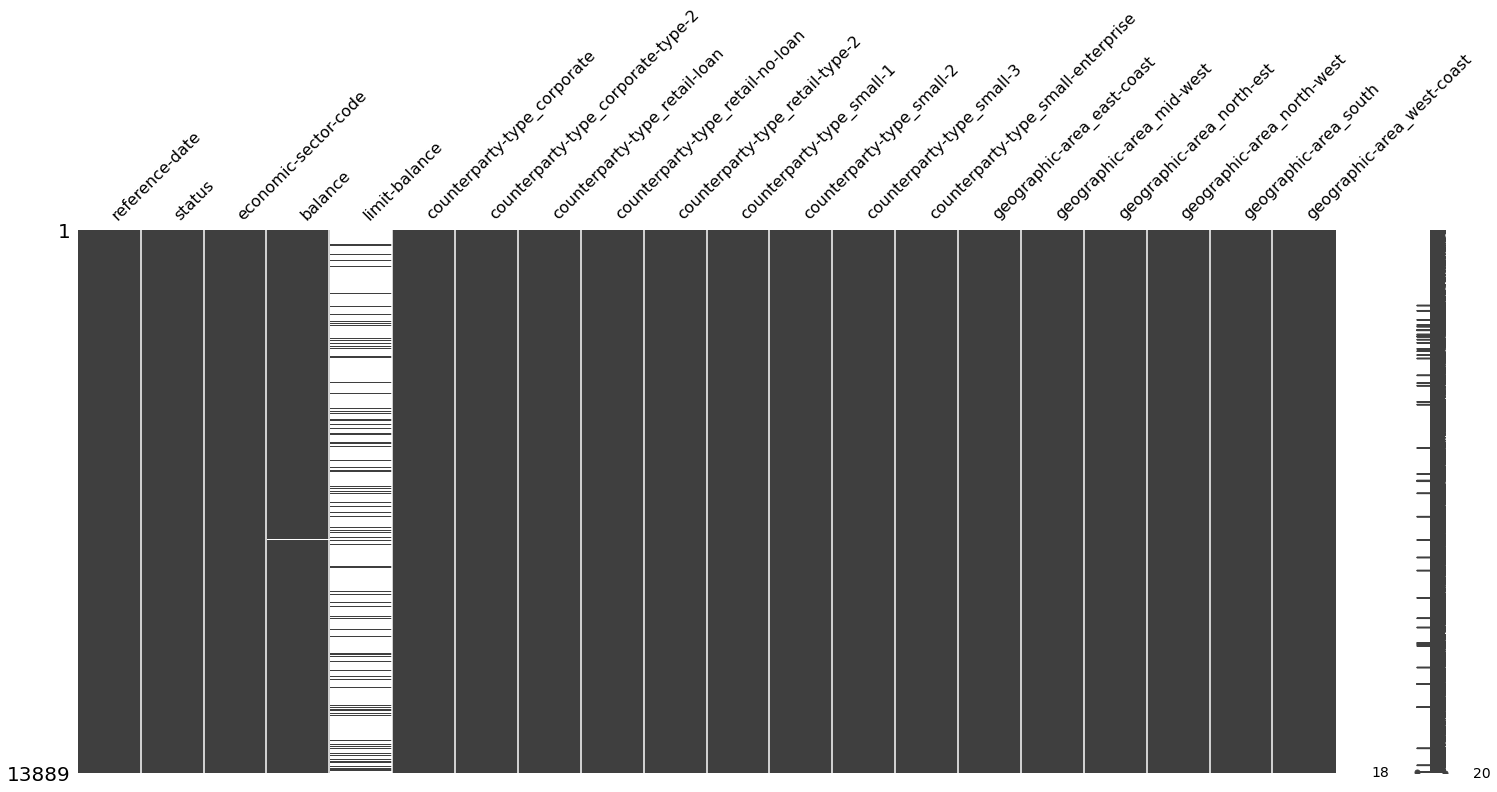

In [63]:
msno.matrix(X)

<AxesSubplot:>

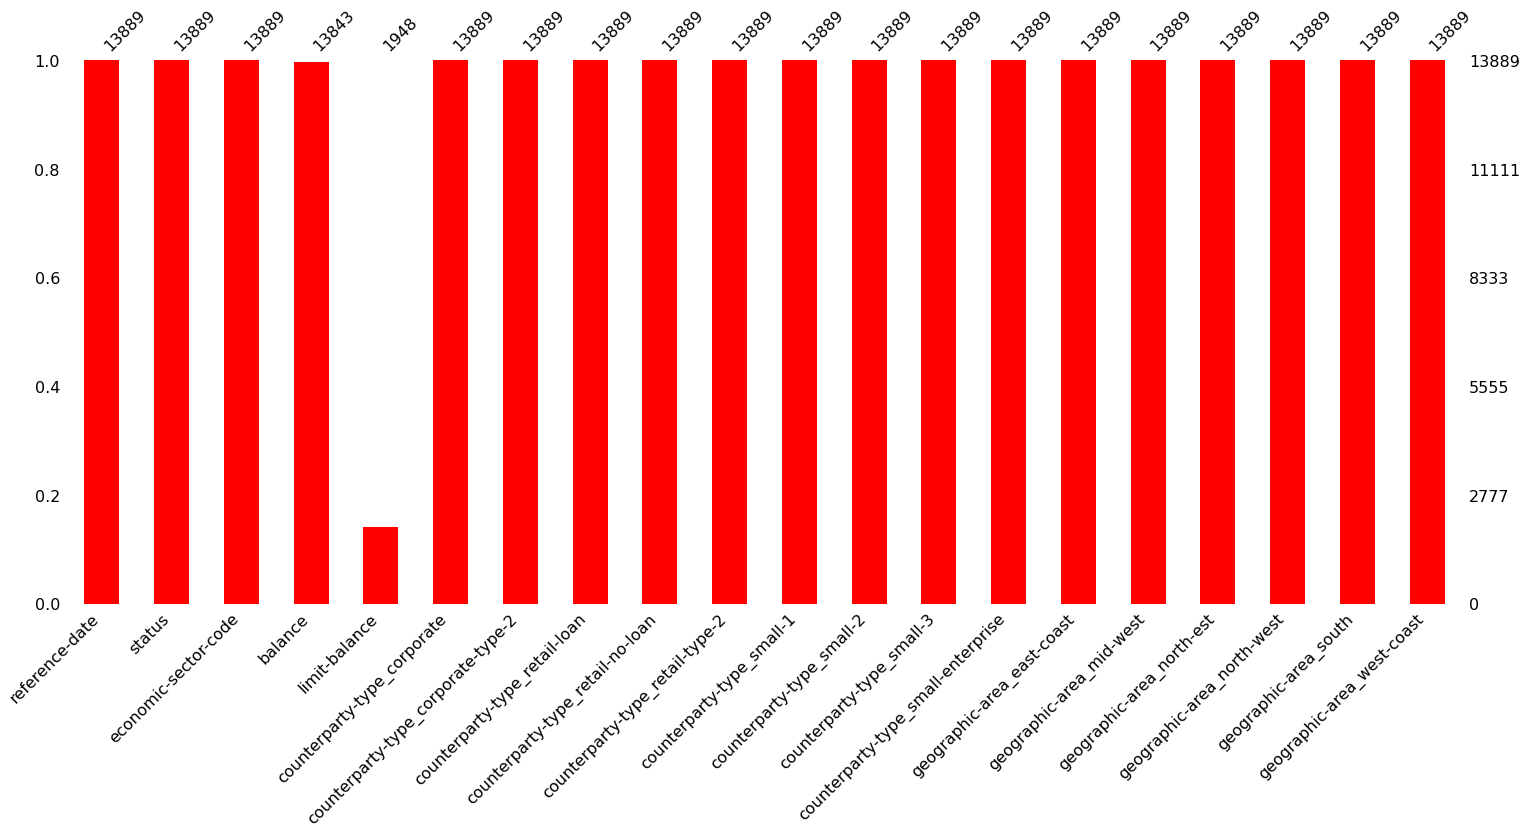

In [64]:
msno.bar(X, color="red")

We are observing 2 things :
- The variable `limit-balance` has only almost 2000 values different from `NaN` over 14 000 observations
- The variable `balance` has 46 NaN tuples over 14 000. We can easily fill the other values with for instance
    - the mean (or median) of the column
    - the most frequent value of the column

$\longrightarrow$ **Handling `limit-balance`**

In [94]:
X.drop("limit-balance", axis=1, inplace=True)

$\longrightarrow$ **Handling `balance`**

In [95]:
X["balance"].fillna(X["balance"].mean(), inplace=True)

$\longrightarrow$ **Final summary of missing values**

In [96]:
percent_missing = X.isnull().sum() * 100 / len(df)
percent_missing

reference-date                        0.0
status                                0.0
economic-sector-code                  0.0
balance                               0.0
counterparty-type_corporate           0.0
counterparty-type_corporate-type-2    0.0
counterparty-type_retail-loan         0.0
counterparty-type_retail-no-loan      0.0
counterparty-type_retail-type-2       0.0
counterparty-type_small-1             0.0
counterparty-type_small-2             0.0
counterparty-type_small-3             0.0
counterparty-type_small-enterprise    0.0
geographic-area_east-coast            0.0
geographic-area_mid-west              0.0
geographic-area_north-est             0.0
geographic-area_north-west            0.0
geographic-area_south                 0.0
geographic-area_west-coast            0.0
dtype: float64

Once we get a 0% for each column of missing values rate, we can consider the next step !

### Remove High-Correlated Data

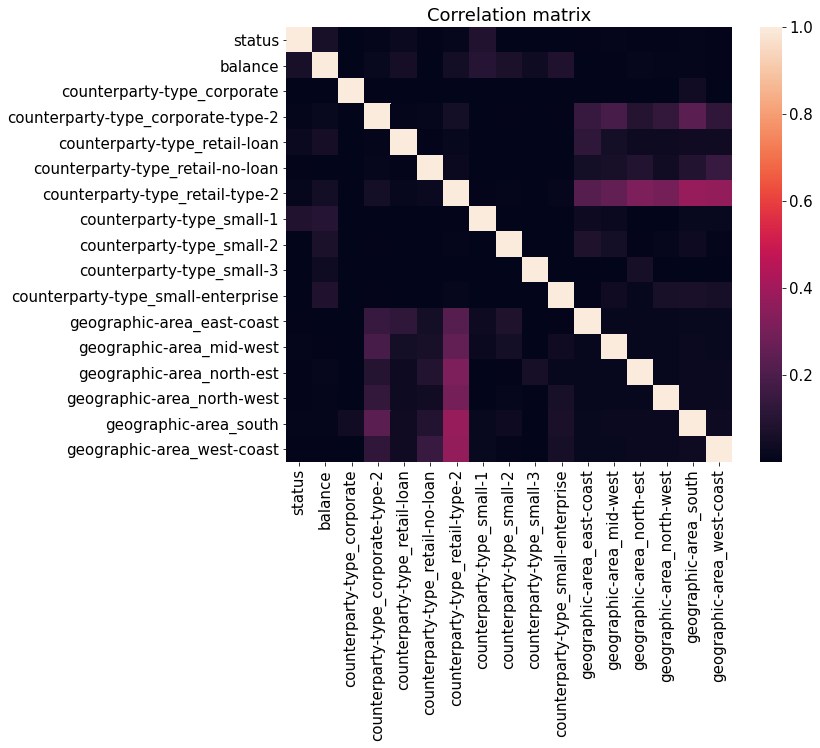

In [97]:
correlation_matrix = X.corr().abs()
sns.heatmap(correlation_matrix, annot=False)
plt.title("Correlation matrix")
plt.show()

In [103]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop selected features
try:
    if len(to_drop) != 0:
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except:
    pass

Finnaly, our dataset at this stage is composed as follows :

In [105]:
X.describe()

,status,balance,counterparty-type_corporate,counterparty-type_corporate-type-2,counterparty-type_retail-loan,counterparty-type_retail-no-loan,counterparty-type_retail-type-2,counterparty-type_small-1,counterparty-type_small-2,counterparty-type_small-3,counterparty-type_small-enterprise,geographic-area_east-coast,geographic-area_mid-west,geographic-area_north-est,geographic-area_north-west,geographic-area_south,geographic-area_west-coast
count,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000,13889.000000
mean,52.850745,5770.881936,0.000072,0.025344,0.002736,0.007560,0.098063,0.000288,0.000864,0.000072,0.002016,0.014256,0.018216,0.019296,0.018720,0.035208,0.028728
std,935.769127,38498.261502,0.008485,0.157173,0.052237,0.086622,0.297411,0.016969,0.029382,0.008485,0.044856,0.118548,0.133736,0.137568,0.135539,0.184311,0.167046
min,1.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,18.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,42.640000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,130.680000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20000.000000,984669.050000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


---

## Exercise 2 - Classification with Support Vector Machines (SVM)

In this exercise you will have to use the data reported in the file **exercise-1-2.csv** which contains a series of data related to diagnostic images. The data relate to a number of characteristics found during breast cancer analyzes. You must use the SVM method to correctly classify the data. Remember to divide the data into a training set and a test set, then measure the effectiveness of your method. Finally, produce the confusion matrix related to your analysis.

### Loading data and import libraries

In [10]:
# Attempt to remove old values for used variables
try:
    del df
    del X
    del X_train, X_test, Y_train, Y_test
except:
    pass

# Importing relevant libraries
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats.mstats import winsorize
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import *
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Settings
plt.rcParams.update({'font.size': 15, 'figure.figsize': (10, 8)}) # set font and plot size to be larger
warnings.filterwarnings("ignore")

# Reading & Declaration the main dataset file
filename = "exercise-1-2.csv"
df = pd.read_csv(filename, index_col="id", na_values=np.nan)

We recover some statistical indicators from each column :

In [11]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
radius_mean,569.0,14.13,3.52,6.98,11.70,13.37,15.78,28.11
texture_mean,569.0,19.29,4.30,9.71,16.17,18.84,21.80,39.28
perimeter_mean,569.0,91.97,24.30,43.79,75.17,86.24,104.10,188.50
area_mean,569.0,654.89,351.91,143.50,420.30,551.10,782.70,2501.00
smoothness_mean,569.0,0.10,0.01,0.05,0.09,0.10,0.11,0.16
compactness_mean,569.0,0.10,0.05,0.02,0.06,0.09,0.13,0.35
concavity_mean,569.0,0.09,0.08,0.00,0.03,0.06,0.13,0.43
concave points_mean,569.0,0.05,0.04,0.00,0.02,0.03,0.07,0.20
symmetry_mean,569.0,0.18,0.03,0.11,0.16,0.18,0.20,0.30
fractal_dimension_mean,569.0,0.06,0.01,0.05,0.06,0.06,0.07,0.10


### Data pre-processing & Data cleaning

$\longrightarrow$ **Dropping useless column** <b style="color:red">$\Longrightarrow$ DANGER : we have NaN values</b>

In [12]:
df.drop("Unnamed: 32", axis = 1, inplace = True)

$\longrightarrow$ **Checking for NaN values**

<AxesSubplot:>

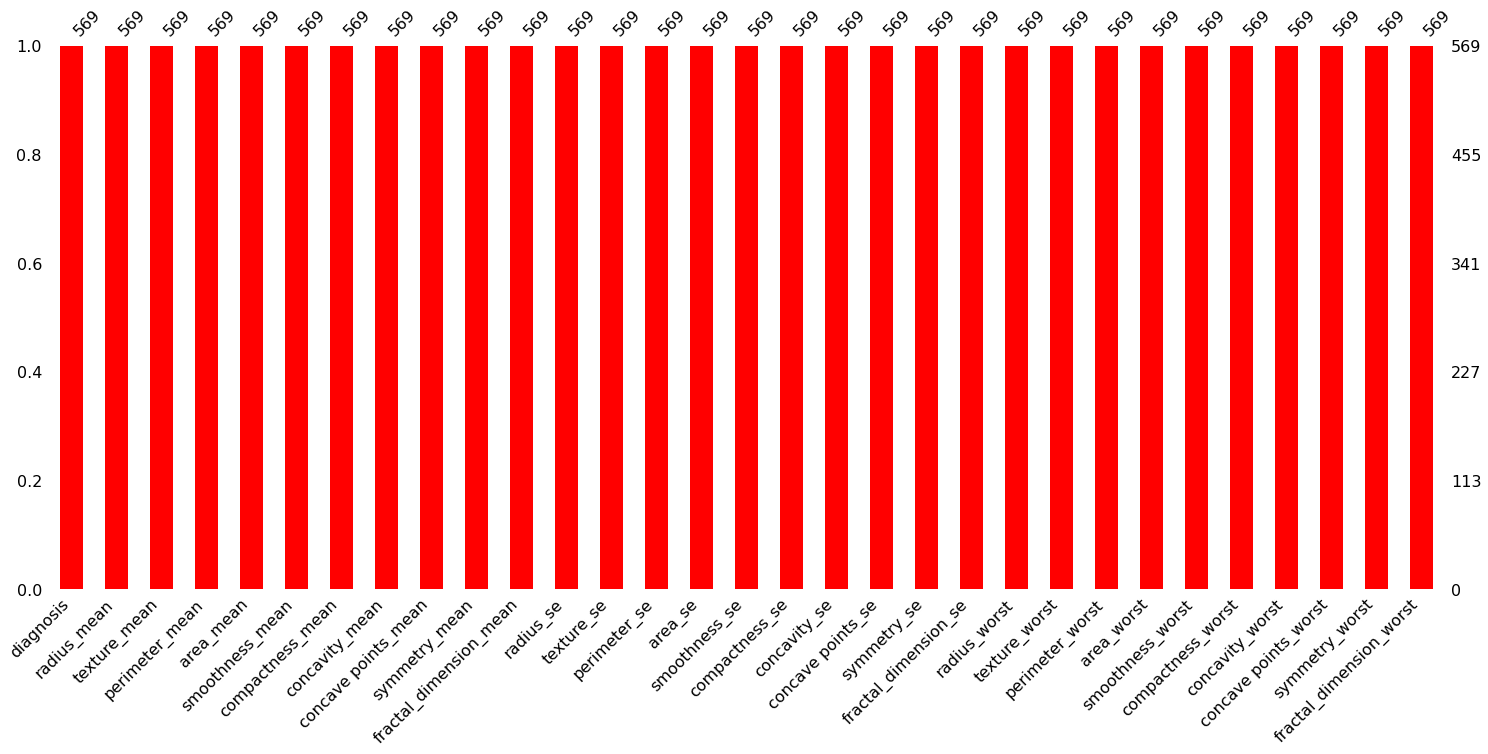

In [13]:
msno.bar(df, color="red")

In [14]:
df.dropna(inplace=True) # just in case, to be sure

In [15]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820


We can see that we don't have any missing values in the dataset ! $\Longrightarrow$ No pre-processing for NaN values needed !

$\longrightarrow$ **Binarization of the target column**

In [16]:
df["diagnosis"] = (df["diagnosis"] == "M").astype(int)

$\longrightarrow$ **Feature normalization** 

In [17]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

In [18]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
842517,1.0,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
84300903,1.0,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
84348301,1.0,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
84358402,1.0,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,1.0,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,0.336364,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
926682,1.0,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,0.349495,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
926954,1.0,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,0.267677,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909


$\longrightarrow$ **Splitting dataset into $X$ and $Y$ dataframes**

In [19]:
X = df.copy()
Y = X.pop("diagnosis")
Y.astype("int")

id
842302      1
842517      1
84300903    1
84348301    1
84358402    1
           ..
926424      1
926682      1
926954      1
927241      1
92751       0
Name: diagnosis, Length: 569, dtype: int64

$\longrightarrow$ **Handling outliers** <b style="color:red">$\Longrightarrow$ AFTER train/test split AND ONLY on train set</b>

### Visual Analysis of Data

In this case you have a very large number of features and clearly you cannot make an n-dimension plotter! Try to select pairs of variables that can be informative...

We have $31$ variables : 
- 1 target variable : `diagnosis` 
- 30 explanatory variables

In reality, we have 10 real variables, with which we have created 3 columns representing the `mean`, `se` (standard error) and `worst`.

The variable `diagnosis` is constructed as binary one.

$\Longrightarrow$ According to this dataset structure, we expect to "explain" the `diagnosis` variable thanks to the data provided by the other columns.

<AxesSubplot:title={'center':'smoothness as function of radius'}, xlabel='radius_mean', ylabel='smoothness_mean'>

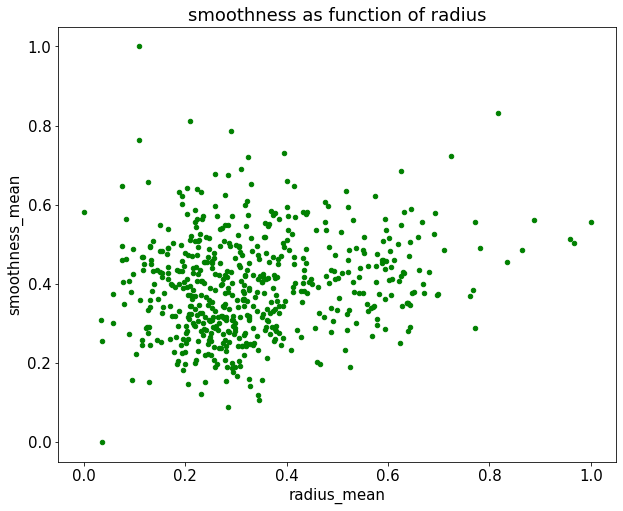

In [25]:
df.plot(kind="scatter",
       x="radius_mean",
       y="smoothness_mean",
       title="smoothness as function of radius",
       color="green")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(1, 0, 'diagnosis'),
  Text(2, 0, 'radius_mean'),
  Text(3, 0, 'texture_mean'),
  Text(4, 0, 'perimeter_mean'),
  Text(5, 0, 'area_mean'),
  Text(6, 0, 'smoothness_mean'),
  Text(7, 0, 'compactness_mean'),
  Text(8, 0, 'concavity_mean'),
  Text(9, 0, 'concave points_mean'),
  Text(10, 0, 'symmetry_mean'),
  Text(11, 0, 'fractal_dimension_mean'),
  Text(12, 0, 'radius_se'),
  Text(13, 0, 'texture_se'),
  Text(14, 0, 'perimeter_se'),
  Text(15, 0, 'area_se'),
  Text(16, 0, 'smoothness_se'),
  Text(17, 0, 'compactness_se'),
  Text(18, 0, 'concavity_se'),
  Text(19, 0, 'concave points_se'),
  Text(20, 0, 'symmetry_se'),
  Text(21, 0, 'fractal_dimension_se'),
  Text(22, 0, 'radius_worst'),
  Text(23, 0, 'texture_worst'),
  Text(24, 0, 'perimeter_worst'),
  Text(25, 0, 'area_worst'),
  Text(26, 0, 'smoothness_worst'),
  Text(27, 0, 'compactness_w

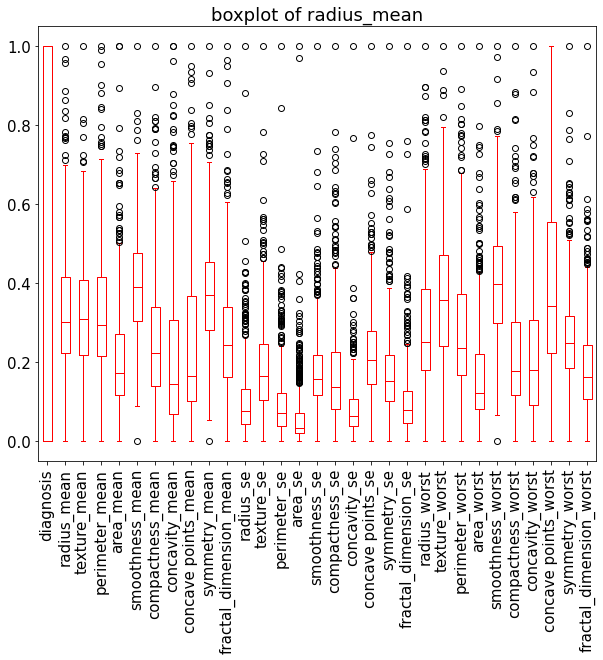

In [26]:
df.plot(kind="box",
       title="boxplot of radius_mean",
       color="red", xlabel=None)
plt.xticks(rotation=90)

As you can see, we have a lot of outliers

<AxesSubplot:xlabel='radius_mean'>

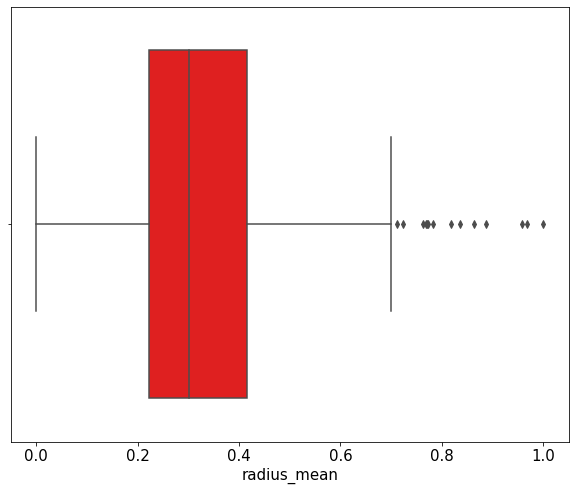

In [27]:
sns.boxplot(x = df["radius_mean"], color="red")

<b style="color: red">Important remark</b> : SVM is not <ins>very robust to outliers</ins>. Presence of a few outliers can lead to very bad
global misclassification.


**Reference** : https://lstat.kuleuven.be/research/lsd/lsd2008/presentationslsd3/Debruyne.pdf

We can easily remove the outliers **but this will narrow our dataset**. Indeed, if we drop the value, we have to remove all the corresponding row.

$\Longrightarrow$ Instead, we will use the **Winsorize method** to replace the outliers by "normal values".

-0.06630697146102532 0.7060911543376402


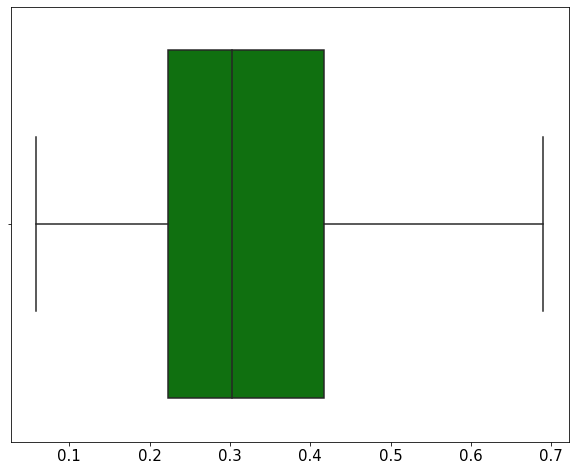

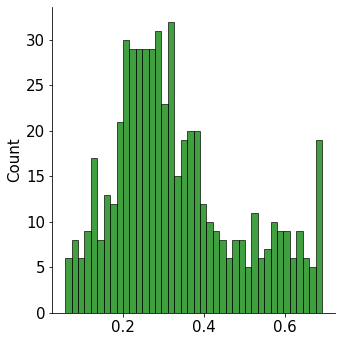

In [28]:
# Computation of IQR : Interquartile Range
Q1 = df["radius_mean"].quantile(0.25)
Q3 = df["radius_mean"].quantile(0.75)
IQR = Q3 - Q1

# Kind of "scale" parameter
alpha = 1.5
lower_boundary = Q1 - alpha*IQR
upper_boundary = Q3 + alpha*IQR
print(lower_boundary, upper_boundary)

# Apply the winsorized method on the first feature column
new_df_rm = winsorize(df["radius_mean"], (0.01, 0.03))

# Plot the new bloxplot and the new distplot
sns.boxplot(x = new_df_rm, color="green")
sns.displot(x = new_df_rm, bins = 40, kde = False, color="green")

There is no outliers anymore. 


#### Extension of this method to each column
$\Longrightarrow$ We can extend this method for the other columns. 

$\Longrightarrow$ We will see that on the current dataframe <b style="color:red">AFTER</b> the train/test split method.

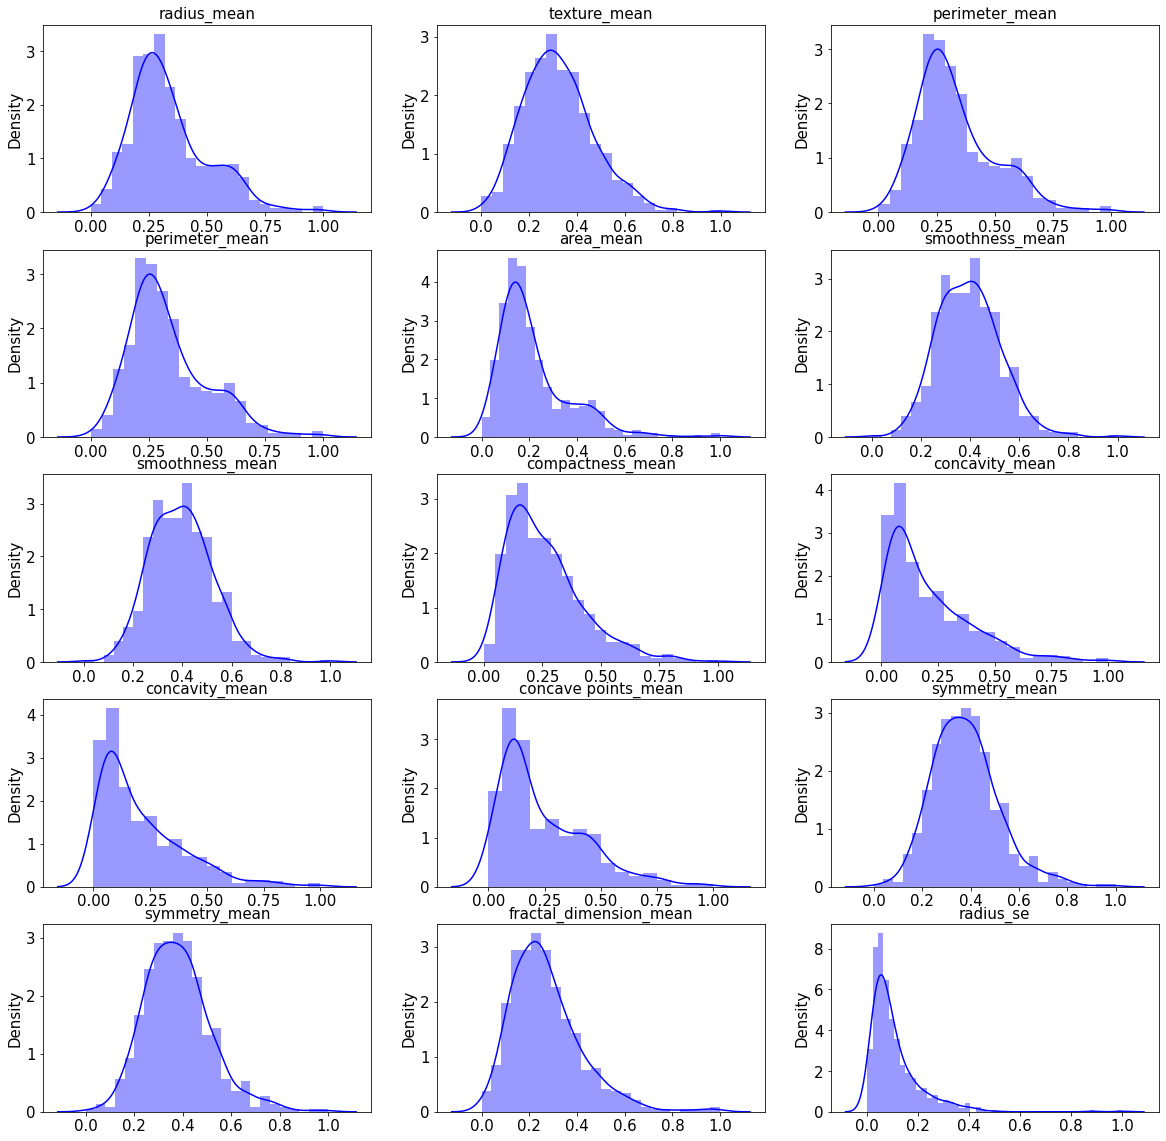

In [29]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(X[X.columns[i*2+j]], ax=ax[i][j], color="blue")
        g.set(xlabel=None)
        g.set_title(X[X.columns[i*2+j]].name, fontsize = 15)

$\Longrightarrow$ As we can see, these plots confirm we'll have to **perform the same operation** on the whole dataset.

### Dealing with correlated variables

Text(0.5, 1.0, 'Correlation matrix')

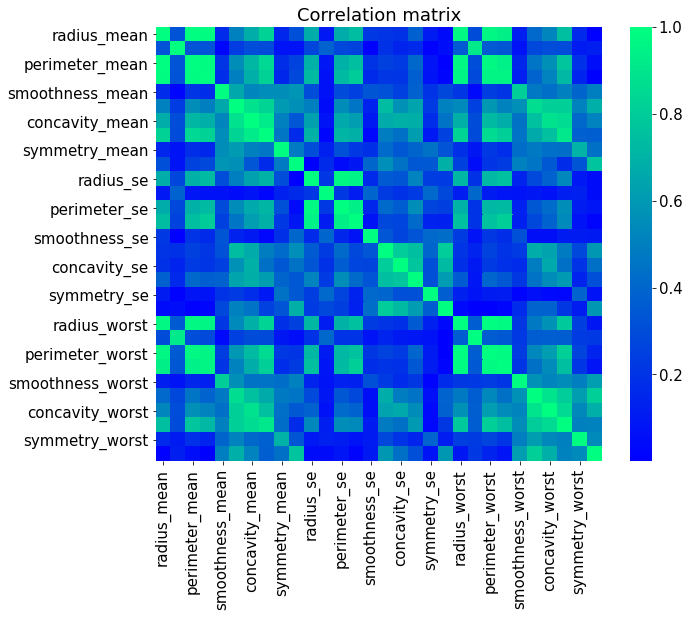

In [32]:
correlation_matrix = X.corr().abs()
sns.heatmap(correlation_matrix, annot=False, cmap="winter")
plt.title("Correlation matrix")

We can drop the most correlated variables as below :

In [33]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
#print(to_drop)

# Drop selected features
try:
    if len(to_drop) != 0:
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except:
    pass

Removing high-correlated columns


### Create Training and Test Dataset

$\longrightarrow$ **Train/Test dataset split**

In [34]:
# Size setting
size_sample_test = 0.2

# Creation of training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size_sample_test)

$\longrightarrow$ **Detection and replacing of outliers in the dataset**

In [35]:
def apply_outliers_detect_col(col):
    """
    Function returning an outliers-corrected column from the initial column : col
    :param col: Initial column
    """
    return winsorize(col, limits=[0.05, 0.05])

def apply_outliers_detect(df):
    """
    Function returnin an outliers-corrected dataframe from the initial dataframe : df
    :param df: Initial dataframe
    """
    return df.apply(apply_outliers_detect_col, axis = 0)

# Applying the filtering of outliers on the train dataset ONLY
X_train = apply_outliers_detect(X_train)
X_train

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,
8813129,0.297648,0.247210,0.287262,0.093737,0.083271,0.220202,0.142797,0.065617,0.117243,0.146820,0.066002,0.057045,0.171567,0.097625,0.055318,0.372647,0.100717,0.142652,0.185492,0.138987
91594602,0.381892,0.316537,0.356775,0.204251,0.175398,0.253030,0.193555,0.099402,0.185157,0.110106,0.105507,0.074924,0.178500,0.053864,0.028440,0.352836,0.177363,0.228914,0.141336,0.095107
916838,0.610961,0.356781,0.461045,0.342372,0.330600,0.374747,0.251053,0.143545,0.113486,0.114764,0.156052,0.077071,0.223148,0.053864,0.086239,0.465760,0.294564,0.334265,0.193968,0.238226
886452,0.330304,0.248225,0.514309,0.332863,0.229358,0.428283,0.238837,0.113525,0.099364,0.157664,0.184291,0.078763,0.254215,0.179237,0.062193,0.528495,0.290004,0.256310,0.296274,0.160895
877989,0.499740,0.324992,0.334477,0.308018,0.242737,0.225253,0.104254,0.103422,0.103430,0.148792,0.176030,0.068510,0.254783,0.113384,0.060915,0.441986,0.305333,0.280192,0.268677,0.154991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909777,0.169861,0.291173,0.259908,0.077419,0.046696,0.662626,0.162595,0.025457,0.406604,0.306183,0.083050,0.050328,0.210457,0.130692,0.124276,0.176781,0.044814,0.031837,0.223536,0.080808
925291,0.214350,0.480893,0.360928,0.253727,0.260544,0.176263,0.331508,0.046098,0.406604,0.220519,0.207048,0.144899,0.240008,0.098469,0.132775,0.387176,0.217724,0.289936,0.107826,0.211728
86973702,0.353022,0.184985,0.424935,0.253727,0.198852,0.335354,0.228517,0.046750,0.083805,0.135738,0.155601,0.078636,0.282819,0.093685,0.056424,0.399062,0.238874,0.247843,0.221959,0.142923


### Apply SVM Method

The regularization parameter $C$ serves as a degree of importance that is given to misclassifications. SVM pose a quadratic optimization problem that looks for maximizing the margin between both classes and minimizing the amount of misclassifications. However, for non-separable problems, in order to find a solution, the miclassification constraint must be relaxed, and this is done by setting the mentioned "regularization".

So, intuitively, as lambda grows larger the less the wrongly classified examples are allowed (or the highest the price the pay in the loss function). Then when lambda tends to infinite the solution tends to the hard-margin (allow no miss-classification). When lambda tends to 0 (without being 0) the more the miss-classifications are allowed.

There is definitely a tradeoff between these two and normally smaller lambdas, but not too small, generalize well. Below are three examples for linear SVM classification (binary).

In [36]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 10.0 # SVM regularization parameter

# Create the SVM model
classifier = SVC(kernel='linear', C = C, gamma='auto', random_state=0)

# Fit the model for the data
classifier.fit(X_train, Y_train)

SVC(C=10.0, gamma='auto', kernel='linear', random_state=0)

### Predictions

In [37]:
# Make predictions
Y_pred = classifier.predict(X_test)

### Analyze Accuracy and Confusion Matrix

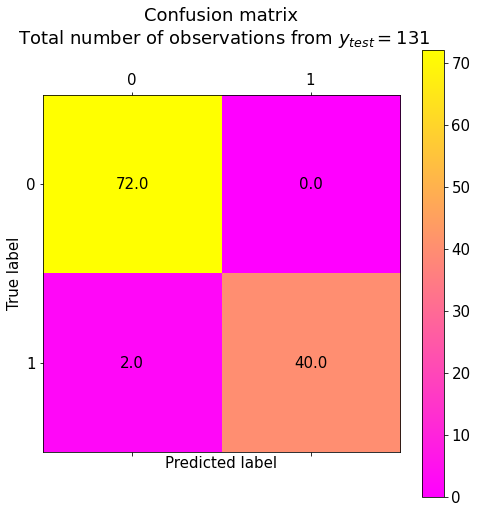

In [38]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Show confusion matrix in a separate window
plt.matshow(cm, cmap="spring")
plt.title('Confusion matrix\n Total number of observations from $y_{{test}} = 131$\n')
plt.colorbar()
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Cross Validation : $K$-Fold

In [39]:
# Setting up K to 10
K = 10
accuracy = cross_val_score(estimator = classifier, X = X_train, y = Y_train, cv= K)

acc = {
    "Accuracy": accuracy.mean()*100,
    "Standard-Error": accuracy.std()*100
}
acc

{'Accuracy': 97.58454106280195, 'Standard-Error': 2.0587873457483767}

We obtain :
- a model accuracy of $97\%$
- a standard deviation of $2$

(0.5, 1.2)

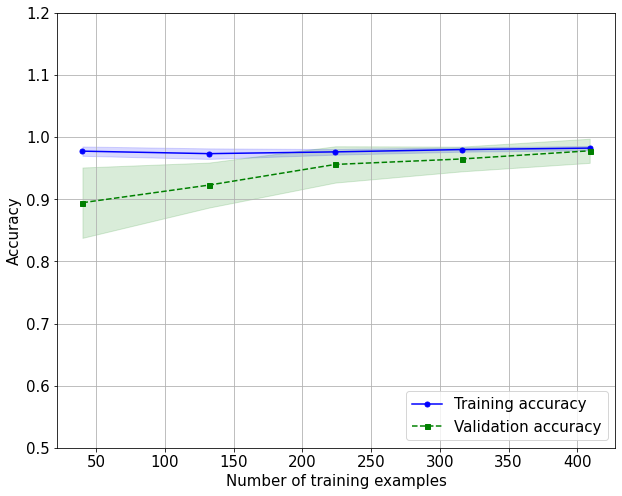

In [40]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=classifier,
    X=X_train,
    y=Y_train,
    #train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Validation accuracy')

plt.fill_between(train_sizes,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5, 1.2))

### Appendix : Confusion matrix composition
<img src="https://i1.wp.com/miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png?zoom=2&w=578&ssl=1" width="400px"/>